In [1]:
import pandas as pd
import numpy as np

In [ ]:
# Препроцессинг

In [2]:
import json
with open('cora_features', 'r')  as f:
    features = json.load(f)

In [3]:
len(features.keys())

2708

In [4]:
edges = pd.read_csv('cora_edges.csv')

In [5]:
edges2 = edges[(edges.Source.isin(np.array(list(features.keys())).astype(int)))&(edges.Target.isin(np.array(list(features.keys())).astype(int)))]

In [6]:
edges2

,Target,Source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960
...,...,...
10551,853155,853115
10552,853155,853116
10553,1140289,853118
10554,853118,853155


In [7]:
old_indexes = np.array(list(features.keys())).astype(int)
new_indexes = range(len(old_indexes))
voc1 = dict(zip(old_indexes, new_indexes))
voc2 = dict(zip(new_indexes, old_indexes))

In [8]:
edges2.Source = edges2.Source.apply(lambda x: voc1[x])
edges2.Target = edges2.Target.apply(lambda x: voc1[x])

In [9]:
edges2

,Target,Source
0,163,402
1,163,659
2,163,1696
3,163,2295
4,163,1274
...,...,...
10551,1902,1885
10552,1902,1886
10553,2258,1887
10554,1887,1902


In [10]:
features2 = dict(zip(new_indexes, features.values()))

In [11]:
edges2

,Target,Source
0,163,402
1,163,659
2,163,1696
3,163,2295
4,163,1274
...,...,...
10551,1902,1885
10552,1902,1886
10553,2258,1887
10554,1887,1902


In [12]:
format_features = list(features2.values())

In [13]:
len(format_features)

2708

In [14]:
all_pairs = edges2.groupby('Source').Target.apply(list)

In [15]:
#Cоставление последовательностей, чтобы во время обучения соблюдалась размерность. Тут пока BFS используется только для этого
def bfs(graph, start):
    path = []
    queue = [start]
    while queue:
        vertex = queue.pop(0)
        if (vertex not in path):
            path.append(vertex)
            queue.extend(set(graph[vertex]) - set(path))
#             if len(path)%1000==0:
#                 print(len(path))
    return path

In [16]:
import torch
from torch_geometric.data import Data

In [17]:
#Создание графа для нейронной сети
from torch_geometric.utils import remove_isolated_nodes
def create_graph(seq, el_num):
    element = seq[el_num]
    new_seq = seq[:el_num]
    sorted_new_seq = np.sort(new_seq)
    order = [np.where(new_seq==x)[0].item() for x in sorted_new_seq]
    res = np.array(pd.Series(seq[:el_num]).isin(all_pairs[element]).astype(int))
    res = res[order]
    edge_index = torch.tensor(np.array(edges2[(edges2.Source.isin(new_seq)) & (edges2.Target.isin(new_seq))]))
    q = remove_isolated_nodes(edge_index)
    edge_index = torch.tensor(q[0])
    temp = np.zeros(len(format_features))
    temp[:len(q[2])] = q[2]
    x = torch.tensor(format_features)[temp.astype(bool)].float()
    data = Data(x=x, edge_index=edge_index.t().contiguous())
    node_features = format_features[element]
    return(data, res, node_features)

In [18]:
#Создание батча графов для нейронной сети
def create_batch(sequences, el_num):
    graphs = []
    results = []
    features = []
    for i in sequences:
        info = create_graph(i, el_num)
        graphs.append(info[0])
        results.append(info[1])
        features.append(info[2])
    return(graphs, results, features)

In [19]:
len(format_features[0])

1434

In [20]:
path0 = np.load('cora_0.npy')
path1 = np.load('cora_1.npy')

In [21]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
from torch_geometric.nn import avg_pool, global_add_pool
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data, DataLoader, NeighborSampler
from torch.nn import BatchNorm1d, Linear

In [22]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1434, 1000)
        self.conv2 = GCNConv(1000, 700)
        self.conv3 = GCNConv(700, 250)
        self.graph_to_h0 = nn.Linear(1434, 150)
        self.graph_to_c0 = nn.Linear(1434, 150)
        self.lstm = nn.LSTM(250, 150, batch_first = True) 
        self.logits = nn.Linear(150, 1)
    def forward(self, data, features):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        num_graphs = data.num_graphs
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = x.view((num_graphs,int(len(x)/num_graphs),250))
        initial_cell = self.graph_to_c0(features)
        initial_hid = self.graph_to_h0(features)
        state = (initial_cell[None], initial_hid[None])
        lstm_out, state = self.lstm(x, state)
        logits = self.logits(lstm_out)
        res = F.sigmoid(logits)
        return res
        


In [23]:
model = Net()

In [24]:
loader = DataLoader(create_batch([path0, path1], 10)[0], batch_size=2)

In [25]:
#бинарная кроссэнтропия
def computeLoss(network, batch, el_num, batch_size):
    info = create_batch(batch, el_num)
    loader = DataLoader(info[0], batch_size=batch_size)
    res = torch.tensor(info[1]).to(device)
    node_features = torch.tensor(info[2]).float().to(device)
    for i in loader:
        q = i.to(device)
        preds = network.forward(q, node_features.float()).squeeze(-1)
    loss = F.binary_cross_entropy(preds, res.float())
#     del node_features
#     del res
#     del loader
#     del q
    torch.cuda.empty_cache()
    return(loss)


In [26]:
#другая бинарная кроссэнтропия
def computeLoss(network, batch, el_num, batch_size):
    info = create_batch(batch, el_num)
    loader = DataLoader(info[0], batch_size=batch_size)
    res = torch.tensor(info[1]).to(device)
    node_features = torch.tensor(info[2]).float().to(device)
    for i in loader:
        q = i.to(device)
        preds = network.forward(q, node_features.float()).squeeze(-1)
    loss = nn.BCELoss()
    loss_val = loss(preds, res.float())
#     del node_features
#     del res
#     del loader
#     del q
    torch.cuda.empty_cache()
    return(loss_val)

In [49]:
#Взвешанная бинарная кроссэнтропия, которая не работает ни с какими весами
def computeLoss(network, batch, el_num, batch_size):
    info = create_batch(batch, el_num)
    loader = DataLoader(info[0], batch_size=batch_size)
    res = torch.tensor(info[1]).to(device)
    node_features = torch.tensor(info[2]).float().to(device)
    for i in loader:
        q = i.to(device)
        preds = network.forward(q, node_features.float()).squeeze(-1)
    pos_weight = torch.tensor([500])
    loss = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    loss_val = loss(preds, res.float())
#     del node_features
#     del res
#     del loader
#     del q
    torch.cuda.empty_cache()
    return(loss_val)

In [50]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
# device = torch.device('cpu')
model = Net()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), 
                       lr=1e-3)

In [51]:
#чтение нагенерированных bfs последовательностей для обучения.
train = []
test = []
for i in range(250):
    if len(np.load('cora_'+str(i)+'.npy')) == 2485 :
        train.append(np.load('cora_'+str(i)+'.npy'))
for i in range(250,500):
    if len(np.load('cora_'+str(i)+'.npy')) == 2485:
        test.append(np.load('cora_'+str(i)+'.npy'))
train = torch.tensor(train)
test = torch.tensor(test)

In [52]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
#функция, которая выводит предикт, и показывает, насколько он адекватный
def get_pred(network, batch, el_num, batch_size):
    info = create_batch(batch, el_num)
    loader = DataLoader(info[0], batch_size=batch_size)
    res = torch.tensor(info[1]).to(device)
    node_features = torch.tensor(info[2]).float().to(device)
    for i in loader:
        q = i.to(device)
        preds = network.forward(q, node_features.float()).squeeze(-1)
    return(preds, res)

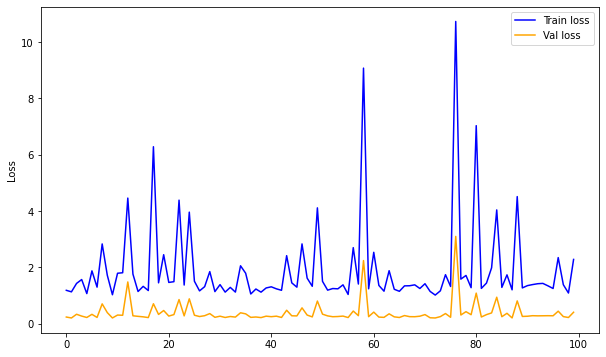

tensor([0.3921, 0.3806, 0.3780, 0.3773, 0.3760, 0.3758, 0.3752, 0.3739, 0.3728,
        0.3725, 0.3718, 0.3717, 0.3704, 0.3700, 0.3699, 0.3696, 0.3687, 0.3682,
        0.3678, 0.3677, 0.3675, 0.3675, 0.3675, 0.3674, 0.3673, 0.3673, 0.3672,
        0.3658, 0.3658, 0.3657, 0.3655, 0.3652, 0.3652, 0.3647, 0.3647, 0.3646,
        0.3646, 0.3644, 0.3644, 0.3644, 0.3644, 0.3644, 0.3646, 0.3642, 0.3642,
        0.3642, 0.3642, 0.3642, 0.3643, 0.3640, 0.3640, 0.3642, 0.3638, 0.3641,
        0.3635, 0.3635, 0.3635, 0.3637, 0.3635, 0.3634, 0.3634, 0.3634, 0.3634,
        0.3634, 0.3634, 0.3634, 0.3634, 0.3635, 0.3634, 0.3632, 0.3638, 0.3626,
        0.3627, 0.3626, 0.3626, 0.3625, 0.3625, 0.3625, 0.3625, 0.3625, 0.3625,
        0.3625, 0.3625, 0.3630, 0.3622, 0.3622, 0.3622, 0.3622, 0.3625, 0.3619,
        0.3619, 0.3621, 0.3618, 0.3618, 0.3617, 0.3618, 0.3617, 0.3618, 0.3617,
        0.3621, 0.3613, 0.3614, 0.3613, 0.3612, 0.3612, 0.3613, 0.3614, 0.3611,
        0.3611, 0.3611, 0.3611, 0.3611, 

In [53]:
#обучение, где в каждой эпохе проходится  n_batches_per_epoch батчей в эпоху, и тестится на n_validation_batches в эпоху на данных, которую четь не видела
#train loss должен быть выше val_loss по началу, но если нейронка правильно учится, постепенно val_loss должен стать выше train_loss
num_epoch = 100
n_batches_per_epoch = 2
batch_size = 10
n_validation_batches = 10
train_losses = []
val_losses = []
for epoch in range(num_epoch):
    train_loss= 0
    val_loss = 0
    model.train(True)
    order = np.random.permutation(len(train))
    order2 = np.random.permutation(len(test))
    indexes = np.random.randint(3, 2485, n_batches_per_epoch)
    for _ in (indexes):
        optimizer.zero_grad()
        batch_indexes = order[0:0+batch_size]
        x_batch = train[batch_indexes]
        x_batch = list(np.array(x_batch))
        loss_value = computeLoss(model, x_batch, _, batch_size)
        loss_value.backward()
        optimizer.step()
        train_loss += loss_value.item()
    train_loss /= (n_batches_per_epoch)
    train_losses.append(train_loss)
    model.train(False)
    for _ in (indexes):
        batch_indexes = order2[0:0+batch_size]
        x_batch = test[batch_indexes]
        x_batch = list(np.array(x_batch))
        loss_value = computeLoss(model, x_batch, _, batch_size)
        val_loss += loss_value.item()
    val_loss /= (n_validation_batches)
    val_losses.append(val_loss)
    clear_output()
    plt.figure(figsize = (10, 6))
    plt.plot(train_losses, label = 'Train loss', color = 'blue')
    plt.plot(val_losses, label = 'Val loss', color = 'orange')
    plt.legend()
    plt.ylabel('Loss')
    plt.show()
    print(get_pred(model, [path1], 1000, 1)[0][0])

In [ ]:
path0

In [ ]:
create_batch([path0], 100)